# Great Britain emissions

Here we will explore Great Britain's emissions and ask whether or not they are on track to meeting their emissions pledges.
"On track" will be defined as their current emissions being less than that of a scenario with uniform decrease in emissions. 

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import pandas as pd
from openclimate import Client

In [2]:
# create an openclimate Client object
client = Client()
client.jupyter

## Get data
We will the emissions data from UNFCCC to perform this analysis. 

In [3]:
actor_id = 'GB'
client.emissions_datasets(actor_id)

,actor_id,datasource_id,name,publisher,published,URL
0,GB,BP:statistical_review_june2022,"Statistical Review of World Energy all data, 1...",BP,2022-06-01T00:00:00.000Z,https://www.bp.com/en/global/corporate/energy-...
1,GB,EDGARv7.0:ghg,Emissions Database for Global Atmospheric Rese...,JRC,2022-01-01T00:00:00.000Z,https://edgar.jrc.ec.europa.eu/dataset_ghg70
2,GB,GCB2022:national_fossil_emissions:v1.0,Data supplement to the Global Carbon Budget 20...,GCP,2022-11-04T00:00:00.000Z,https://www.icos-cp.eu/science-and-impact/glob...
3,GB,PRIMAP:10.5281/zenodo.7179775:v2.4,PRIMAP-hist_v2.4_no_extrap (scenario=HISTCR),PRIMAP,2022-10-17T00:00:00.000Z,https://zenodo.org/record/7179775
4,GB,UNFCCC:GHG_ANNEX1:2019-11-08,"UNFCCC GHG total without LULUCF, ANNEX I count...",UNFCCC,2019-11-08T00:00:00.000Z,https://di.unfccc.int/time_series
5,GB,carbon_monitor:2022_12_14,Carbon Monitor country CO2 emissions by sector,Carbon Monitor,2022-12-14T00:00:00.000Z,https://carbonmonitor.org/
6,GB,climateTRACE:country_inventory,climate TRACE: country inventory,climate TRACE,2022-12-02T00:00:00.000Z,https://climatetrace.org/inventory
7,GB,WRI:climate_watch_historical_ghg:2022,Climate Watch Historical GHG Emissions,WRI,2022-01-01T00:00:00.000Z,https://www.climatewatchdata.org/ghg-emissions
8,GB,openGHGmap:R2021A,European OpenGHGMap,NTNU,2021-01-01T00:00:00.000Z,https://openghgmap.net/data/
9,GB,BEIS:UK_regional_GHG:2022-06-30,UK local authority and regional greenhouse gas...,BEIS,2022-06-30T00:00:00.000Z,https://www.gov.uk/government/statistics/uk-lo...


In [4]:
emissions_datasource = 'UNFCCC:GHG_ANNEX1:2019-11-08'
df_gb = client.emissions(actor_id=actor_id, datasource_id=emissions_datasource)
df_ndc = client.targets(actor_id=actor_id)

# convert tonnes to megatonnes
df_gb['total_emissions'] = df_gb['total_emissions'] / 10**6

# filter ndc by target
filt = df_ndc['datasource_id']=='IGES:NDC_db:10.57405/iges-5005'
df_ndc = df_ndc.loc[filt]

The UK has pledged to reduce their emissions by 68% from 1990 levels by 2030.

In [5]:
df_ndc

,actor_id,target_type,baseline_year,baseline_value,target_year,target_value,target_unit,datasource_id
0,GB,Absolute emission reduction,1990.0,None,2030,68,percent,IGES:NDC_db:10.57405/iges-5005


A quick look at their emissions we see that Great Britain's emissions have been decreasing for the last thirty years. But this brings up a a couple questions:
- Is GB "on-track" to meeting this goal?
- Will GB meet their goal if this long-term trend continues?

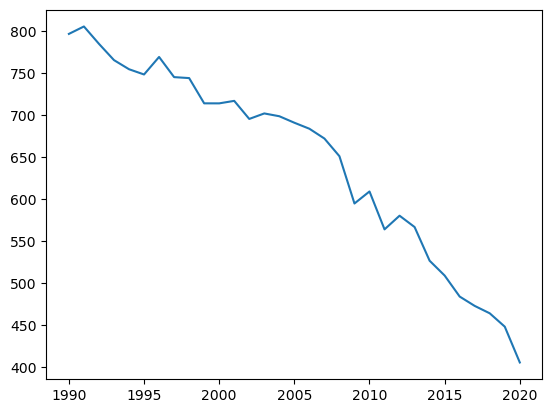

In [6]:
plt.plot(np.array(df_gb['year']), np.array(df_gb['total_emissions']))

## Is Great Britain on track?

To answer this question, we will simply ask if the current emissions are less than if the emissions decreased uniformly from baseline to their goal. We will also ask whether GB will meet their goal if the long-term trend contintues. 
Keep in mind that both of these are crude and imperfect metrics. More sophistiated approaches including using integrated assessment models (IAMs) that incorporate proposed actions. 

In [7]:
# implementation normal equations for ordinary least squares regression 
def linear_eq(df, start_year=None, year_var='year', emissions_var='total_emissions'):
    '''simple linear regression'''
    filt = df[year_var]>=start_year
    x = df.loc[filt, year_var].values
    y = df.loc[filt, emissions_var].values

    # least-squares linear regression
    n = len(x)
    sum_x = np.sum(x)
    sum_y = np.sum(y)
    sum_xy = np.sum(x * y)
    sum_xx = np.sum(x * x)
    mean_x = np.mean(x)
    mean_y = np.mean(y)

    # calculate coefficients
    b = (n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x**2)
    a = mean_y - b * mean_x

    # Make predictions using the regression line
    pred = lambda x: a + b * x
    return {'equation':pred, 'slope':b, 'intercept':a}

In [8]:
baseline_year = df_ndc['baseline_year'].values[0]
current_year = df_gb['year'].max()
net_zero_year = 2050
target_year = df_ndc['target_year'].values[0]
target_value = int(df_ndc['target_value'])
target_percent = float(df_ndc['target_value'].squeeze())/100

pred = linear_eq(df_gb, start_year=baseline_year)
X_pred = np.arange(baseline_year, target_year + 1)
Y_pred = pred['equation'](X_pred)

# get baseline and target emissions 
filt = df_gb['year'] == baseline_year
baseline_emissions = df_gb.loc[filt,'total_emissions']
target_emissions = df_gb.loc[filt,'total_emissions'] * (100 - target_value)/100
net_zero_emissions = 0 

# current emissions
filt = df_gb['year'] == current_year
current_emissions = df_gb.loc[filt,'total_emissions']

# average annual reduction needed to achieve goal:
avg_rate = round(((baseline_emissions - target_emissions) / (target_year - baseline_year + 1)).values[0])
nz_rate = round(((baseline_emissions - net_zero_emissions) / (net_zero_year - baseline_year + 1)).values[0])

year_target_achieved = round((target_emissions - pred['intercept']) / pred['slope'])
print(f"To acheive goal, average rate of reduction needs to be {abs(avg_rate):.0f} MT/yr")
print(f"To acheive net-zero goal, average rate of reduction needs to be {abs(nz_rate):.0f} MT/yr")
print(f"GB reducing emissions by about {abs(pred['slope']):.0f} MT/yr")
print(f'Target emissions of {int(target_emissions.values)} MT/yr will be acheived around {int(year_target_achieved.values)}')

To acheive goal, average rate of reduction needs to be 13 MT/yr
To acheive net-zero goal, average rate of reduction needs to be 13 MT/yr
GB reducing emissions by about 12 MT/yr
Target emissions of 255 MT/yr will be acheived around 2037


From this quick analysis, we can see that GB maybe be slightly off track to meeting their goals

## Plot of emissions and pledges



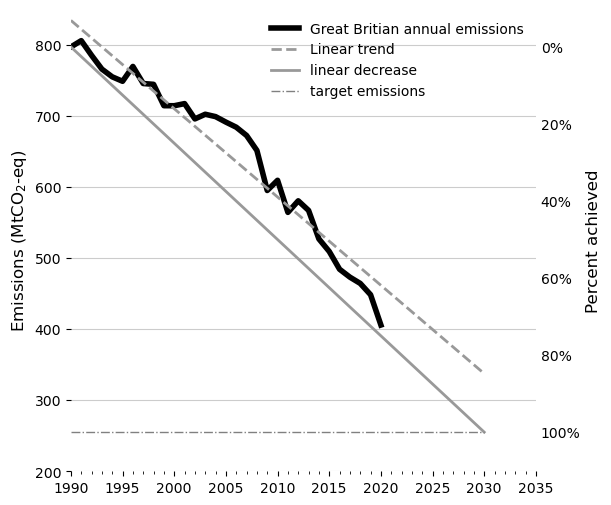

In [9]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.plot(np.array(df_gb['year']), np.array(df_gb['total_emissions']), 
        linewidth=4, 
        label='Great Britian annual emissions',
       color=[0.0,0.0,0.0])

ax.plot(X_pred, Y_pred, '--', 
        linewidth=2, 
        color=[0.6,0.6,0.6],
       label='Linear trend')

ax.plot(np.array([baseline_year, float(target_year)]), np.array([float(baseline_emissions), float(target_emissions)]), 
        '-', 
        linewidth=2, 
        color=[0.6,0.6,0.6],
       label='linear decrease')


ax.plot([df_ndc['baseline_year'], df_ndc['target_year']],
        [target_emissions, target_emissions], 
        '-.', 
        linewidth=1, 
        color=[0.5,0.5,0.5],
       label='target emissions')

ylim = [200, 850]
ax.set_ylim(ylim)
ax.set_xlim([1990, 2035])

# Turn off the display of all ticks.
ax.tick_params(which='both',     # Options for both major and minor ticks
               top='off',        # turn off top ticks
               left='off',       # turn off left ticks
               right='off',      # turn off right ticks
               bottom='off')     # turn off bottom ticks

# Remove x tick marks
plt.setp(ax.get_xticklabels(), rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# major/minor tick lines
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis='y', 
        which='major', 
        color=[0.8, 0.8, 0.8], linestyle='-')

bline_emissions = baseline_emissions.values[0]
ylim_achieved = [(bline_emissions - ylim[0])/ (bline_emissions*target_percent)*100,
                 (bline_emissions - ylim[1])/ (bline_emissions*target_percent)*100]
ax2 = ax.twinx()
ax2.set_ylim(ylim_achieved)

# Hide the right and top spines
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

# Only show ticks on the left and bottom spines
ax2.yaxis.set_ticks_position('right')
ax2.xaxis.set_ticks_position('bottom')
ax2.yaxis.set_tick_params(size=0)

# Set the y-axis tick labels using a FixedFormatter
vals = ax2.get_yticks()
ax2.yaxis.set_major_locator(plt.FixedLocator(vals))
ax2.set_yticklabels([f"{int(x)}%" for x in vals])

ax2.set_ylabel("Percent achieved", fontsize=12)
ax.set_ylabel("Emissions (MtCO$_2$-eq)", fontsize=12)
ax.legend(loc='upper right', frameon=False)

Now let's do the same for net zero

In [10]:
pred = linear_eq(df_gb, start_year=baseline_year)
X_pred = np.arange(baseline_year, net_zero_year + 1)
Y_pred = pred['equation'](X_pred)

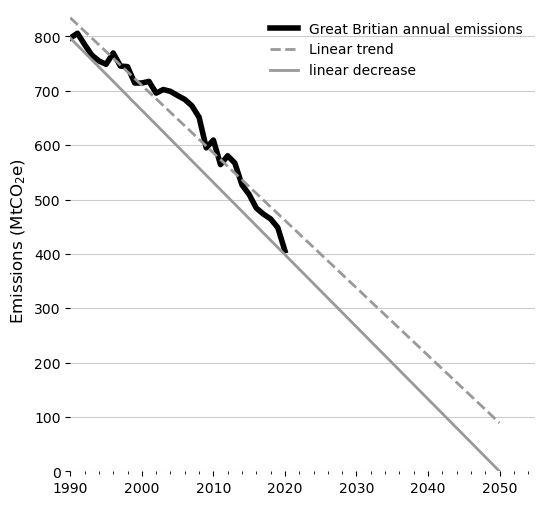

In [11]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.plot(np.array(df_gb['year']), np.array(df_gb['total_emissions']), 
        linewidth=4, 
        label='Great Britian annual emissions',
       color=[0.0,0.0,0.0])

ax.plot(X_pred, Y_pred, '--', 
        linewidth=2, 
        color=[0.6,0.6,0.6],
       label='Linear trend')

ax.plot(np.array((baseline_year, float(net_zero_year))), np.array((float(baseline_emissions), net_zero_emissions)), 
        '-', 
        linewidth=2, 
        color=[0.6,0.6,0.6],
       label='linear decrease')

ylim = [0, 850]
ax.set_ylim(ylim)
ax.set_xlim([1990, 2055])

# Turn off the display of all ticks.
ax.tick_params(which='both',     # Options for both major and minor ticks
               top='off',        # turn off top ticks
               left='off',       # turn off left ticks
               right='off',      # turn off right ticks
               bottom='off')     # turn off bottom ticks

# Remove x tick marks
plt.setp(ax.get_xticklabels(), rotation=0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# major/minor tick lines
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.grid(axis='y', 
        which='major', 
        color=[0.8, 0.8, 0.8], linestyle='-')

bline_emissions = baseline_emissions.values[0]
ylim_achieved = [(bline_emissions - ylim[0])/ (bline_emissions*target_percent)*100,
                 (bline_emissions - ylim[1])/ (bline_emissions*target_percent)*100]

ax.set_ylabel("Emissions (MtCO$_2$e)", fontsize=12)
ax.legend(loc='upper right', frameon=False)

In general, the emissions have been trending in the right direction over the past 30 years, but emissions will have to decline at an increasing rate in order to achieve these goals. 